# Notebook for Delayed correlation (causality)

In [57]:
#Import libraries used in notebooks
import pandas as pd
from scipy import stats
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import matplotlib.patches as mpatches

## Import Data

In [124]:
#Import Data
CleanDataAllGoals=pd.read_pickle('CleanDataAllGoals') #Data in Dataframe format
#Import correlation data
CorrelationAllGoals=pd.read_pickle('CorrelationAllGoals')

In [222]:
#Check correct correlation
CorrelationAllGoals;

## Delayed Correlation

Code to perform delayed correlation by 3 year shift

In [220]:
IndA = 'SN_ITK_DEFCN--' #Indicator A is indicator we want to correlate with all its connections
delayCor=CleanDataAllGoals.copy() #Copy clean data
delayCor.columns=delayCor.columns.get_level_values(2) #Simplify Column Headers to only have series code
delayCor = delayCor.loc[:,~delayCor.columns.duplicated()] #Drop duplicate columns
a=delayCor.loc[2000:2020,IndA]#Original indicator A
a0=delayCor.loc[2000:2017,IndA]#Original indicator without last 3 years (2000-2017)
a3=delayCor.loc[2003:2020,IndA]#indicator shifted 3 years (2003-2020)

#Set New dataframe for results
DelayCorrDF = pd.DataFrame(index=['Unshifted Correlation','Correlation with '+ a0.name+' and col ind delayed','Correlation with '+a0.name+' delayed','Weak Causality'])
delayCor.drop(columns=IndA,inplace=True) #Drop column of indicator A you are looking at so correlation is not calculated with itself
#Set values to 0 or empty list to ensure no errors when rerunning code
CausedByA = 0
CausedByB = 0
NoDirection = 0
indNameA = []
indNameB = []

#Loop through data for length of indicators 
for x in range(0,len(delayCor.columns)):
    #For each column where there is a new series code, indicator B is indicator being compared to indicator A
    b=delayCor.iloc[:,x] #Set b to original indicator
    b0=delayCor.iloc[:-3,x] #Set b0 to indicator without last 3 years (2000-2017)
    b3=delayCor.iloc[3:,x] #Set b3 to indicator shifted 3 years (2003-2020)
    
    #Making sure both original a,b and shift a,b have at least 10 values, 
    #for scipy spearman correlation no in built method for selecting minimum number of data pairs
    if len(a0)-np.isnan(a0).sum()>=10: #Takes length of data minus sum of nan values, must be equal or greater than 10 real data values to be considered
        if len(a3)-np.isnan(a3).sum()>=10:
            if len(b0)-np.isnan(b0).sum()>=10:
                if len(b3)-np.isnan(b3).sum()>=10:
                    cor0, pval0 = stats.spearmanr(a,b,nan_policy='omit') #Perform correlation on unshifted values
                    cor, pval = stats.spearmanr(a0,b3,nan_policy='omit') #Perform correlation with indicator B in the future
                    cor2, pval2 = stats.spearmanr(b0,a3,nan_policy='omit') #Perform correlation with indicator A in the future
                    
#if correlation is above 0.6 then need pvalue less than 0.05 to be significant, 
#if correlation below 0.6 then p value not as important as null is no correlation and it is trending towards that
                    if (pval0<0.05 and cor0>=0.6): #Original correlation must be greater than or equal to 0.6 and be significant (p value<0.05)
                        if (pval<0.05 and abs(cor)>=0.6) or abs(cor)<0.6: #Shifted correlation must be greater than or equal to 0.6 and significant or less than threshold
                            if (pval2<0.05 and abs(cor2)>=0.6) or abs(cor)<0.6: #Shifted correlation must be greater than or equal to 0.6 and significant or less than threshold
                                cause=abs(cor)-abs(cor2) #Calculate absolute difference between shifted correlation values
                            
#Want to count the number of indicators with an effect on A and that feel an effect on A and those with no direction
                                if cause>0:
                                    CausedByA = CausedByA + 1 #Number of indicators that feel an effect from A
                                    indNameA.append(b.name) 
                                if cause<0:
                                    CausedByB = CausedByB + 1 #Number of indicators with an effect on A
                                    indNameB.append(b.name)
                                if cause == 0:
                                    NoDirection = NoDirection + 1 #Number of indicators with no effect
                                    
#Only interested in causality that is large as shows a definite direction so only keep if weak causality > x (x=0.3/0.4/0.5 depending on how large a difference you want)
                                if abs(cause)>0.4:
                                    DelayCorrDF[b0.name] = [cor0,cor,cor2,cause] #Add original correlation, B shifted correlation, A shifted correlation and difference in shifted correlation

/Applications/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [221]:
# A = original indicator (in index)
# B = indicator in column 
#For weak causality positive number implies A has a greater influence on the future of B
#a negative number implies B has a greater influence on the future of A
# Allows a direction to be determined
DelayCorrDF.sort_values('Weak Causality',axis=1,ascending=True) #Sort for causality values so max negative (B causes A) on left and max positive (A causes B) on right

,SN_STA_OVWGTN--<5Y_,EN_LKRV_PWAP--,EG_ACS_ELEC--URBAN_,EN_LKRV_PWAN--,SE_TOT_CPLR--PRIMAR_URBAN_Q3_BOTHSEX_,EN_LKRV_SWAP--,SE_AGP_CPRA--UPPSEC_ALLAREA__T_,EN_LKRV_SWAN--,SE_TOT_CPLR--PRIMAR_URBAN__T_FEMALE_,EN_MAT_DOMCMPG--COL_,...,SE_TOT_CPLR--PRIMAR_URBAN_Q1_FEMALE_,SE_TOT_CPLR--PRIMAR_URBAN_Q4_BOTHSEX_,EN_RSRV_MNWAN--,EN_RSRV_MXWAP--,EN_RSRV_MNWAP--,EN_RSRV_MXWAN--,SE_TOT_CPLR--PRIMAR_URBAN_Q2_MALE_,NV_IND_MANFPC--ISIC4_C_,SE_TOT_CPLR--PRIMAR_RURAL_Q3_FEMALE_,SE_TOT_CPLR--PRIMAR_URBAN__T_MALE_
Unshifted Correlation,0.850549,0.834445,0.607644,0.841758,0.945055,0.646865,0.780220,0.652747,0.967033,0.617582,...,0.972527,0.901099,0.995604,0.986813,0.998900,0.986813,0.912088,0.635165,0.917582,0.950549
Correlation with SN_ITK_DEFCN-- and col ind delayed,0.160440,0.081952,0.000000,0.160440,0.258242,0.338127,0.247253,0.353846,0.296703,-0.314286,...,0.461538,0.450549,0.529670,0.539054,0.544054,0.556044,0.384615,-0.393407,0.461538,0.478022
Correlation with SN_ITK_DEFCN-- delayed,0.958042,0.868202,0.752618,0.860140,0.915152,0.986014,0.890909,0.986014,0.927273,0.937063,...,0.939394,0.927273,1.000000,1.000000,1.000000,1.000000,0.818182,0.825175,0.890909,0.903030
Weak Causality,-0.797602,-0.786250,-0.752618,-0.699700,-0.656910,-0.647887,-0.643656,-0.632168,-0.630569,-0.622777,...,-0.477855,-0.476723,-0.470330,-0.460946,-0.455946,-0.443956,-0.433566,-0.431768,-0.429371,-0.425008


In [224]:
#Print number of indicators that feel an effect from A, Cause an effect on A and have no overall direction
print(('A Causes B:',CausedByA),('B Causes A:',CausedByB),('No Direction:',NoDirection))

('A Causes B:', 31) ('B Causes A:', 238) ('No Direction:', 10)


### Visualising causality

/var/folders/5h/nl7cgmvx6cv0_q4zj9wkhhg00000gn/T/ipykernel_8373/2962234268.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['1','0.75','0.5','0.25','0','0.25','0.5','0.75','1'])


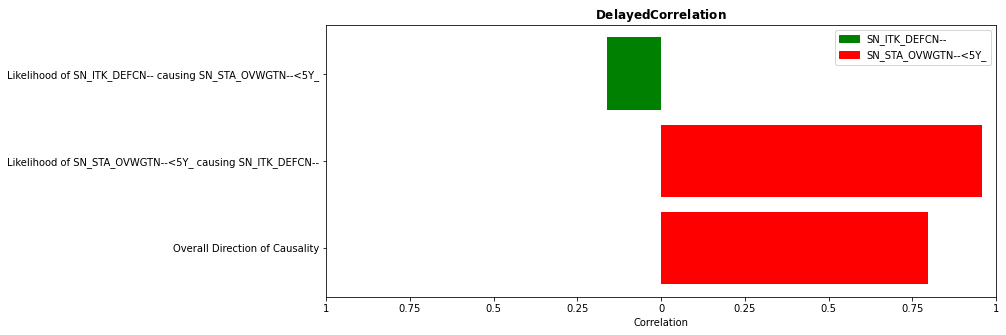

In [227]:
IndB = 'SN_STA_OVWGTN--<5Y_' #Name of indicator B in Dataframe you want to compare with A

#Colours of indicators
IndicatorA = mpatches.Patch(color='green', label=IndA)
IndicatorB = mpatches.Patch(color='red', label=IndB)
#To plot need to adjust values
# First entry is How well A Predicts B (absolute value taken)
# Second entry is How well B predicts A (absolute value taken then made negative purely for plotting purposes)
# Third entry is overall direction of causality (left/green is A causes B, right/red is B causes A)

#Getting values from dataframe [A causing B, B causing B, Overall direction]
causalityValues = [abs(DelayCorrDF.loc[DelayCorrDF.index[1],IndB]),abs(DelayCorrDF.loc[DelayCorrDF.index[2],IndB])*-1,DelayCorrDF.loc['Weak Causality',IndB]]
Width = 0.5 #For bar chart

#Setting colour green if overall value from dataframe positive (A causes B) and red if overall value from dataframe negative (B causes A) 
if DelayCorrDF.loc['Weak Causality',IndB]>0:
    causeColour = 'green'
if DelayCorrDF.loc['Weak Causality',IndB]<0:
    causeColour = 'red'

#Colour map
c = ['green','red',causeColour]

#Plot figure
fig,ax = plt.subplots(1,figsize=(12,5))
#Bar chart with values,width, colour and labels
ax.barh([0,0.6,1.2],causalityValues,Width,color=c,tick_label=['Likelihood of '+ IndA+ ' causing '+IndB,'Likelihood of '+ IndB +' causing '+ IndA,'Overall Direction of Causality'])
plt.xlim([-1,1])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.title(r"$\bf{Delayed Correlation}$")
plt.legend(handles=[IndicatorA,IndicatorB])
#Set tick lables so showing absolute correlation
ax.set_xticklabels(['1','0.75','0.5','0.25','0','0.25','0.5','0.75','1'])
plt.xlabel('Correlation')
plt.show()